# Data Driven Approaches

In this tutorial we want to explore some data driven methods for image reconstruction. We will consider the limited angle CT problem with additonal noise on the sinogram. Our test data will be composed of simple shapes which can be loaded from the utils module.

Let's take a first look at some of the shapes.

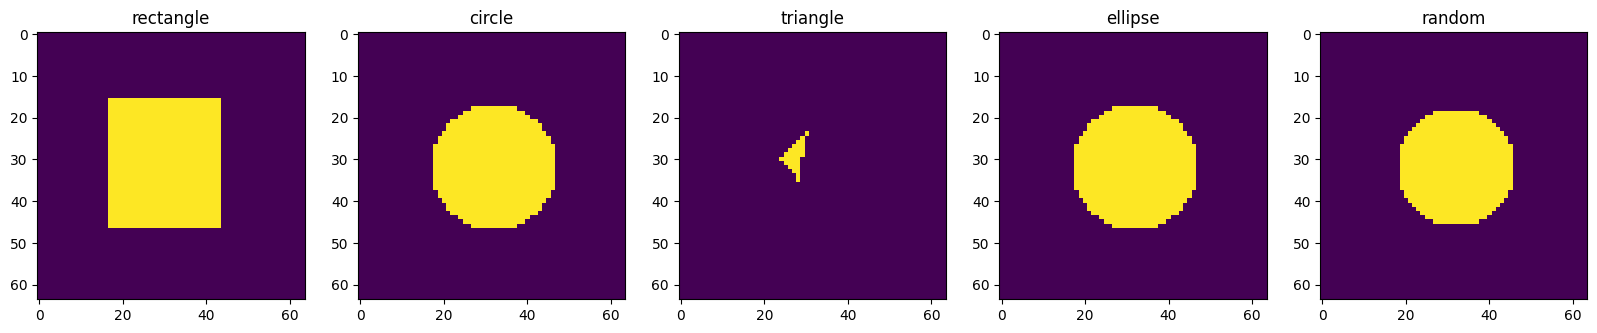

In [272]:
import matplotlib.pyplot as plt
from utils import shapes

img_size = 64 #image size
S = shapes(img_size=img_size, noise_lvl=0.05) # the shape class
shape_names = ['rectangle', 'circle', 'triangle', 'ellipse', 'random'] # all shape names

# plot all shapes
fig, ax = plt.subplots(1,len(shape_names), figsize=(20,15))
for i in range(len(shape_names)):
    ax[i].imshow(S.get_shape(shape_names[i]))
    ax[i].set_title(shape_names[i])

# How does our data look like?
Our data is given as the naive recon of a limited angle CT problem. The next cell defines the function that samples a batch of the data. The second output of the function ```get_data``` is the original input (ground truth) that will be used for the supervised learning scheme.

The original image is returned as a  ```torch``` tensor, since this is more convinient for the training later. Furthermore, inputs and outputs into the net will have the shape

$$
B \times C \times N\times N
$$

where

* $B$ denotes the batch size,
* $C$ the number of channels (we always use $C=1$),
* $N$ the image dimension.

We have to be careful when we compare ```numpy``` and ```torch``` obejcts in the following. If we want to plot a ```torch``` Tensor ```x```, the following steps might be necessary:

* ```x.detach()```: if the tensor ```x``` has a gradient, then we need to detach it first.
* ```x.numpy()```: this converts a ```torch``` tensor without a gradient, to a ```numpy``` array. Commands like ```plt.imshow``` do this internally.
* ```x[b,c,...]```: ```plt.imshow``` only works for 2D arrays, so we have to select one batch element $b$ and a channel $c$.

We now define a routine that returns our data. Basically, we sample a shape $x$ and then also return

$$R^{-1}(R(x) + \delta)$$

as the input to the net, where $R$ is the Radon transform with limited angles ($0^\circ$ to $90^\circ$), and $\delta$ denotes noise. Here, $R^{-1}$ is not the true inverse, but the naive Radon inversion.

In [289]:
import torch
from operators import Radon

num_thetas = 10
min_angle = 0
max_angle = 90
theta = np.linspace(min_angle, max_angle, endpoint = False, num=num_thetas)
R = Radon(theta=theta)

def get_data(batch_size, train_shape, noise_lvl):
    x_recon = np.zeros((batch_size, 1, img_size, img_size))
    x = np.zeros((batch_size, 1, img_size, img_size))

    # set real images and inputs
    for i in range(batch_size):
        x[i,0,...] = S.get_shape(train_shape)
        sinogram =  R(x[i,0,...])
        sinogram += np.random.normal(0, noise_lvl, size=sinogram.shape)
        x_recon[i, 0, ...] = R.inverse(sinogram)

    return x_recon, torch.Tensor(x)

# Let's look at our Data!
The below cell samples data from ```get_data```.

Text(0.5, 1.0, 'Original')

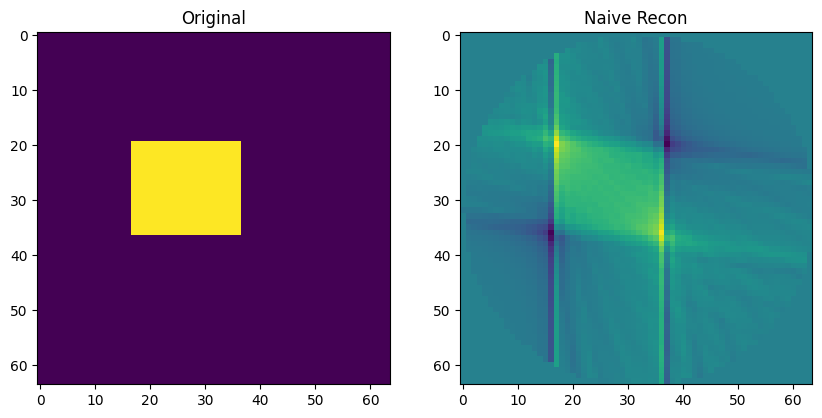

In [302]:
x_recon, x = get_data(5, 'random', 0.00)

fig, ax = plt.subplots(1,2, figsize = (10,8))
ax[1].imshow(x_recon[0,0,...])
ax[1].set_title('Naive Recon')
ax[0].imshow(x.detach()[0,0,...])
ax[0].set_title('Original')

# Loading the model

We now define the neural network model, we want to train in the following. Here, we use the celebrated UNet structure from this paper:

<center>
"Ronneberger, O., Fischer, P., & Brox, T. (2015). U-net: Convolutional networks for biomedical image segmentation. In Medical Image Computing and Computer-Assisted Intervention–MICCAI 2015: 18th International Conference, Munich, Germany, October 5-9, 2015, Proceedings, Part III 18 (pp. 234-241). Springer International Publishing."
</center>

The model architecture is reimplemented (and slightly compressed) in the ```models``` module.

Let's load it.

In [303]:
from models import UNet
model = UNet()

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
num_params = sum([np.prod(p.size()) for p in model_parameters])

print('Loaded the model with ' +str(

In [14]:
import numpy as np
import torch
import torch.nn as nn



noise_lvl = 0.02
loss_fct = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10, eta_min=0)




In [16]:
def train_step(get_data, batch_size=5, train_shape='rectangle'):
    opt.zero_grad()
    x_recon, x = get_data(batch_size, train_shape)
    
    x_model = model(x_recon)
    loss = loss_fct(x_model, x)
    loss.backward()
    opt.step()
    scheduler.step()
    
    loss1 = loss.item()
    loss2 = loss_fct(torch.Tensor(x_recon), torch.Tensor(x)).item()

    if loss1 < best_loss:
        best_model.load_state_dict(model.state_dict())
    print(30*'-')
    print('Epoch: ' + str(epoch))
    print('Current Loss:' + str(loss1))
    print('IRadon Loss:' + str(loss2))
    for param_group in opt.param_groups:
        print('Current lr:' + str(param_group['lr']))

Let's train the net

In [6]:
train_shape = 'circle'
batch_size = 5
epochs = 400

for epoch in range(epochs):
    train_step(get_data, batch_size=batch_size, train_shape=train_shape)

------------------------------
Epoch: 0
Current Loss:0.13388986885547638
IRadon Loss:0.15134425461292267
Current lr:0.0009755282581475768
------------------------------
Epoch: 1
Current Loss:0.10424051433801651
IRadon Loss:0.14527034759521484
Current lr:0.0009045084971874736
------------------------------
Epoch: 2
Current Loss:0.08896356076002121
IRadon Loss:0.1566735953092575
Current lr:0.0007938926261462366
------------------------------
Epoch: 3
Current Loss:0.06923777610063553
IRadon Loss:0.15888170897960663
Current lr:0.0006545084971874737
------------------------------
Epoch: 4
Current Loss:0.056506939232349396
IRadon Loss:0.15394064784049988
Current lr:0.0005
------------------------------
Epoch: 5
Current Loss:0.04387475922703743
IRadon Loss:0.14732582867145538
Current lr:0.00034549150281252633
------------------------------
Epoch: 6
Current Loss:0.044705189764499664
IRadon Loss:0.1590280383825302
Current lr:0.0002061073738537635
------------------------------
Epoch: 7
Current 

In [7]:
## save the model
save_model = False
if save_model:
    torch.save(model.state_dict(), train_shape + '.pt')

In [8]:
load_model = True
if load_model:
    model.load_state_dict(torch.load('circle2.pt'))

Let's look at the results

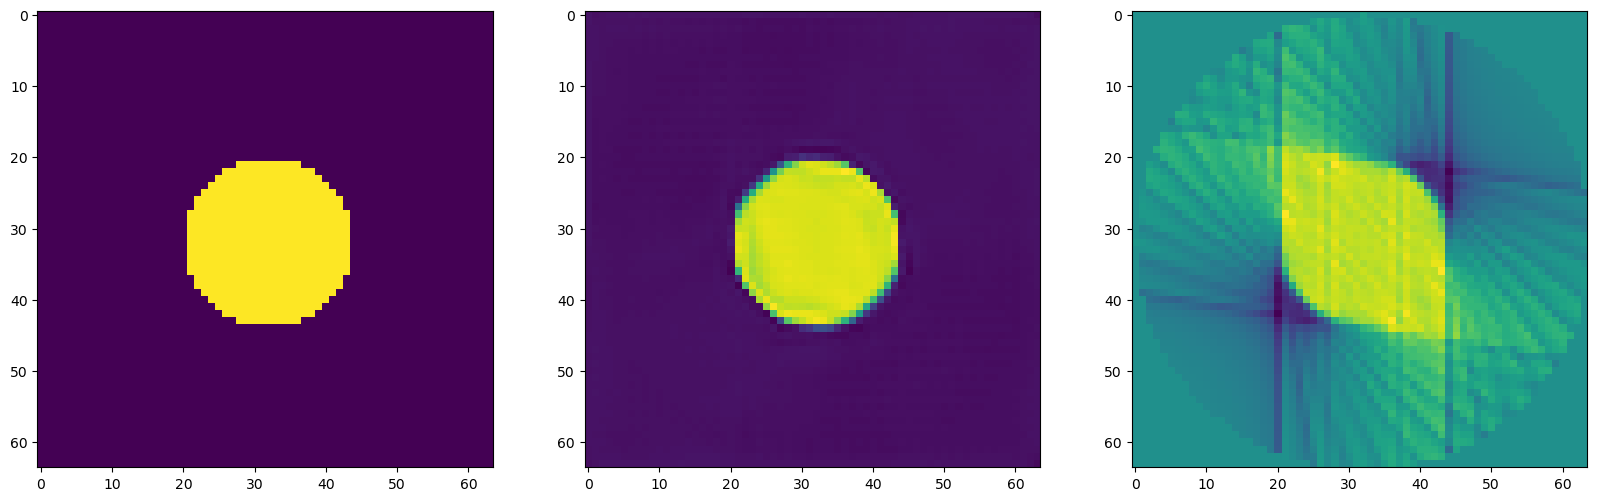

In [13]:
# %% Test
from utils import get_phantom
img_size_test=64
S_test = shapes(img_size=img_size_test)

min_angle = 0
max_angle = 90
theta = np.linspace(min_angle,max_angle, endpoint = False, num=num_thetas)
R = Radon(theta=theta)

test_shape = 'rectangle'
test_shape = 'circle'
#test_shape = 'triangle'
#test_shape = 'ellipse'
I = S_test.get_shape(test_shape)
#I = get_phantom(img_size_test)

I_sino = R(I)
#I_sino += noise(I_sino)
recon = R.inv(I_sino)
model_recon = model(recon)


fig, ax = plt.subplots(1,3, figsize = (20,15))
ax[0].imshow(I)
ax[1].imshow(model_recon.detach()[0,0,...])
ax[2].imshow(recon)

# Train a Denoising Task

In [109]:
num_thetas = 30
min_angle = 0
max_angle = 180
theta = np.linspace(min_angle, max_angle, endpoint = False, num=num_thetas)
R = Radon(theta=theta)

noise_lvl = 0.01
def noise(x):
    return np.random.normal(0, noise_lvl, size=x.shape)

def get_data(batch_size, train_shape):
    x_recon = np.zeros((batch_size, 1, img_size, img_size))
    x = np.zeros((batch_size, 1, img_size, img_size))

    # set real images and inputs
    for i in range(batch_size):
        x[i,0,...] = S.get_shape(train_shape)
        x_recon[i, 0, ...] = x[i,0,...] + noise(x[i,0,...])
    return x_recon, torch.Tensor(x)

Look at the data

Text(0.5, 1.0, 'Original')

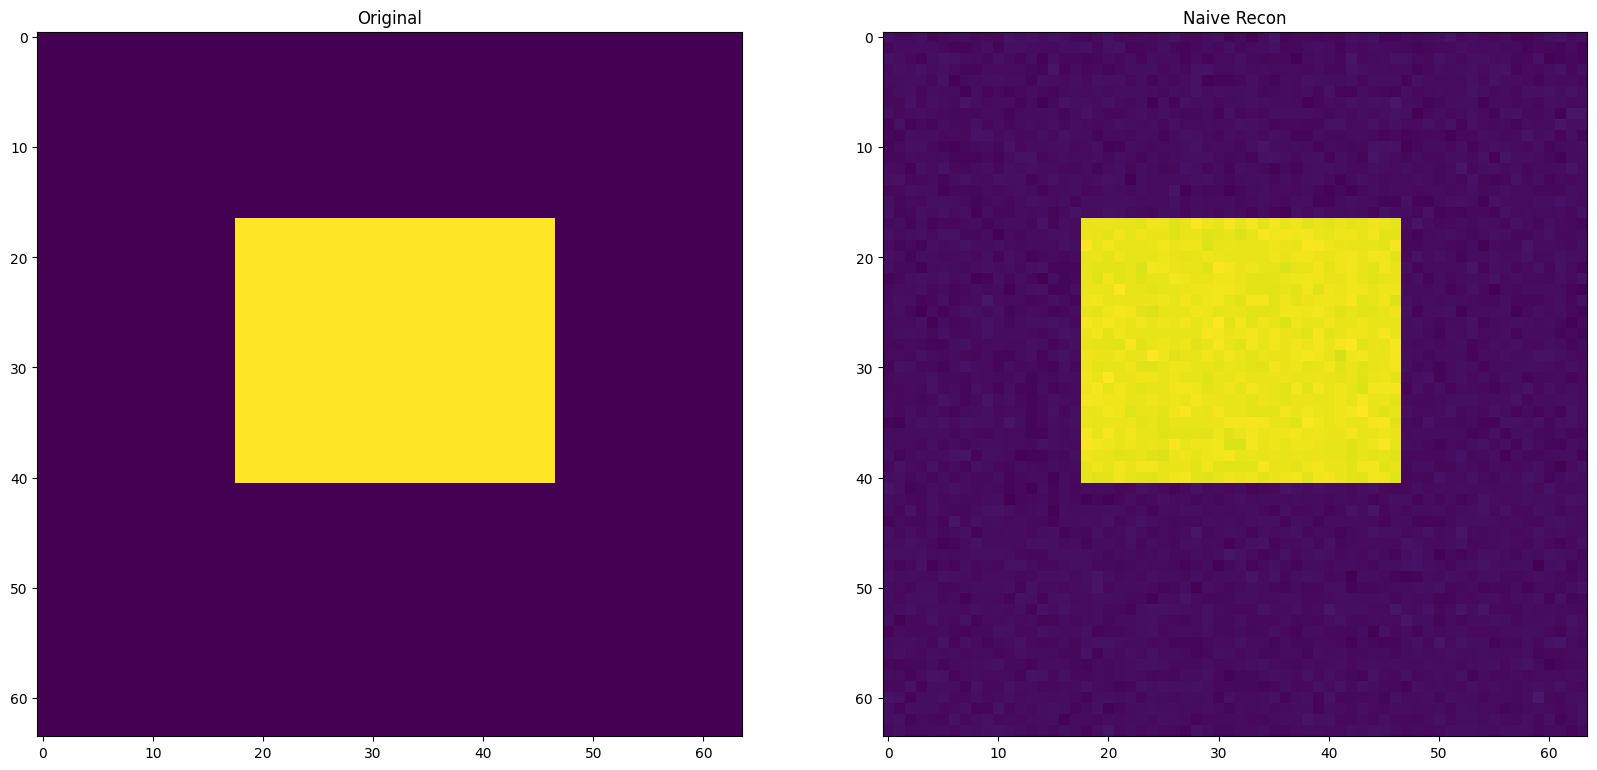

In [110]:
x_recon, x = get_data(5, 'rectangle')

fig, ax = plt.subplots(1,2, figsize = (20,15))
ax[1].imshow(x_recon[0,0,...])
ax[1].set_title('Naive Recon')
ax[0].imshow(x.detach()[0,0,...])
ax[0].set_title('Original')

# Train again

In [118]:
model = UNet()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10, eta_min=0)

In [120]:
train_shape = 'random'
batch_size = 5
epochs = 50

for epoch in range(epochs):
    train_step(get_data, batch_size=batch_size, train_shape=train_shape)

------------------------------
Epoch: 0
Current Loss:0.005362473428249359
IRadon Loss:9.834710363065824e-05
Current lr:0.0009755282581475812
------------------------------
Epoch: 1
Current Loss:0.004755591042339802
IRadon Loss:9.96424350887537e-05
Current lr:0.0009045084971874781
------------------------------
Epoch: 2
Current Loss:0.00415825704112649
IRadon Loss:9.854522068053484e-05
Current lr:0.0007938926261462403
------------------------------
Epoch: 3
Current Loss:0.005485717207193375
IRadon Loss:9.889334614854306e-05
Current lr:0.0006545084971874768
------------------------------
Epoch: 4
Current Loss:0.007268316112458706
IRadon Loss:9.933226829161867e-05
Current lr:0.0005000000000000024
------------------------------
Epoch: 5
Current Loss:0.006315325852483511
IRadon Loss:9.908131323754787e-05
Current lr:0.00034549150281252807
------------------------------
Epoch: 6
Current Loss:0.005556776188313961
IRadon Loss:9.942280303221196e-05
Current lr:0.00020610737385376454
-------------

# How well does it work?

Text(0.5, 1.0, 'Original')

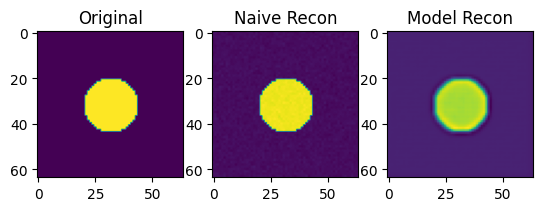

In [126]:
x_recon, x = get_data(5, 'random')

fig, ax = plt.subplots(1,3)
ax[2].imshow(model(x_recon).detach()[0,0,...])
ax[2].set_title('Model Recon')
ax[1].imshow(x_recon[0,0,...])
ax[1].set_title('Naive Recon')
ax[0].imshow(x.detach()[0,0,...])
ax[0].set_title('Original')

In [220]:
from optimizers import optimizer, lv, lscg
from operators import soft_shrinkage

class proxGD(optimizer):
    def __init__(self, A, x, y, t=0.1, lamda=1.0, prox=None, **kwargs):
        super().__init__(**kwargs)
        self.A = A
        self.x = x
        self.y = y
        self.lamda = lamda
        self.t = t
        self.prox = prox if not prox is None else soft_shrinkage
    
    def step(self,):
        grad = self.A.adjoint(self.A(self.x) - self.y)
        lin_up = self.x - 2 * self.t * grad
        self.x = self.prox(lin_up, self.lamda * self.t)


class admm(optimizer):
    def __init__(self, A, x, y, rho=0.1, lamda=1.0, prox=None, max_inner_it=5, **kwargs):
        super().__init__(**kwargs)
        self.A = A
        self.x = x
        self.y = y
        self.lamda = lamda
        self.prox = prox if not prox is None else soft_shrinkage
        self.v = self.prox(self.x ,self.lamda)
        self.u = 0*self.x
        
        self.rho = rho
        
        self.inner_verbosity = 0
        self.max_inner_it = max_inner_it
        
        class cg_op: 
            def __call__(self,x):
                return lv([A(x), rho * 0.5 * x])

            def adjoint(self, p):
                return A.adjoint(p[0]) + rho * 0.5 * p[1]

        self.cg_op = cg_op()

    def step(self):
        inner_rhs = lv([self.y, self.rho * 0.5 * (self.v - self.u)])
        self.x = self.solve_inner(inner_rhs)
        self.v = self.prox(self.x + self.u ,self.lamda)
        self.u = self.u + self.x -self.v

    def solve_inner(self, rhs):
        return lscg(self.cg_op, rhs, self.x, 
                    verbosity = self.inner_verbosity, 
                    max_it=self.max_inner_it).solve()

Text(0.5, 1.0, 'Naive Recon')

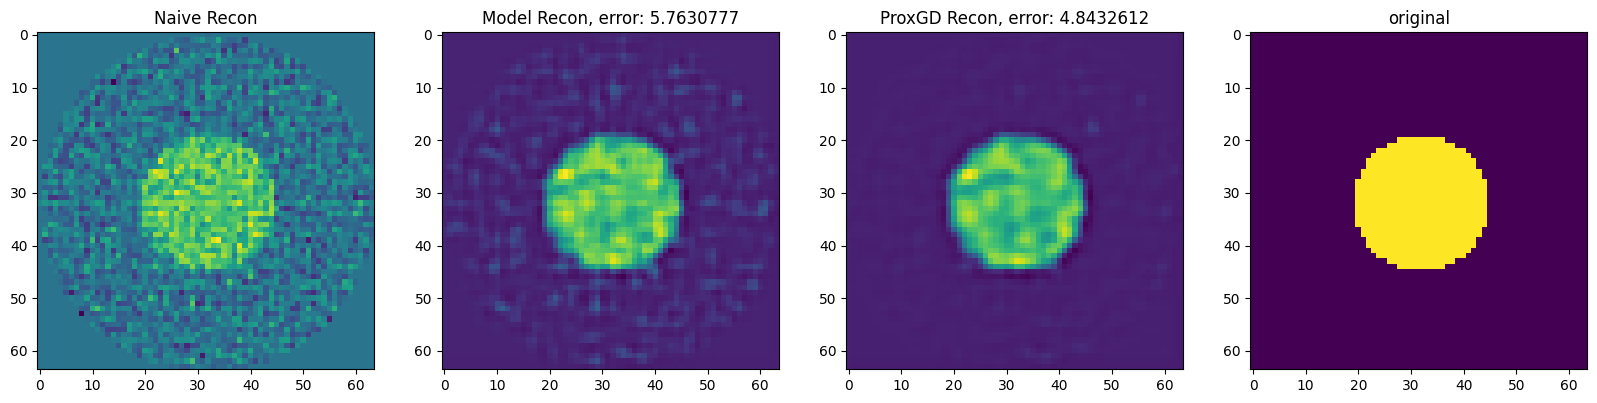

In [267]:
def model_prox(x, lamda):
    lamda = max(min(lamda, 1.),0)
    return (1-lamda) * x + lamda * model(x).detach().numpy()[0,0,...]

noise_lvl = 0.04
def noise(x):
    return np.random.normal(0, noise_lvl, size=x.shape)


x_recon, x = get_data(5, 'random')
Rx = R(x[0,0,...])
Rx += noise(Rx)
x0 = R.inv(Rx)


#x0 = x_recon[0,0,...]
sinogram = R(x0)
#pGD = proxGD(R, x0, Rx, t=0.02, lamda=1., verbosity=0, prox=model_prox, max_it=10)
pGD = admm(R, x0, Rx, rho=0.3, lamda=1., verbosity=0, prox=model_prox, max_it=35, max_inner_it=1)
pGD.solve()

x = x[0,0,...].numpy()
x_model = model(x0).detach().numpy()[0,0,...]
fig, ax = plt.subplots(1,4, figsize=(20,15))
ax[3].imshow(x)
ax[3].set_title('original')
ax[2].imshow(pGD.x)
ax[2].set_title('ProxGD Recon, error: ' + str(np.linalg.norm(pGD.x - x)))
ax[1].imshow(x_model)
ax[1].set_title('Model Recon, error: ' + str(np.linalg.norm(x_model - x)))
ax[0].imshow(x0)
ax[0].set_title('Naive Recon')